<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/Email_Assistant_with_Semantic_%2B_Episodic_%2B_Procedural_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Email Assistant with Semantic + Episodic + Procedural Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Uses human-in-the-loop to refine the assistant's ability to classify emails
- Drafts responses
- Schedules meetings
- Uses memory to remember details from previous emails

Now, we'll add procedural memory that allows the user to update instructions for using the calendar and email writing tools.

### Setup API Keys

In [1]:
import os
from google.colab import userdata
#
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
#
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

### Install required libraries

In [2]:
%pip install -qU langchain langchain-openai langchain-groq langchain_community langchain_core langmem langgraph langchain-huggingface

### Prompt Instructions

In [82]:
profile = {
    "name": "Plaban",
    "full_name": "Plaban Nayak",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [83]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Plaban's tasks efficiently."
}

## Sample Email Input

In [84]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

### Instantiate the Memory Store

In [85]:
from langgraph.store.memory import InMemoryStore
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

In [86]:
store = InMemoryStore(index={"embed": embeddings})

In [87]:
store

### Instantiate LLM

In [9]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=os.getenv("GROQ_API_KEY"))

### Prompts

In [88]:
# Agent prompt baseline
agent_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

# Agent prompt semantic memory
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory("email_assistant", user, "collection") - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. manage_memory("email_assistant", user, "user_profile") - Store any relevant information about the recipient, {name}, in the user profile for future reference the current user profile is shown below
6. search_memory("email_assistant", user, "collection") - Search memory for detail from previous emails
7. manage_memory("email_assistant", user, "instructions") - Update the instructions for agent tool usage based upon the user feedback
</ Tools >

< User profile >
{profile}
</ User profile >

< Instructions >
{instructions}
</ Instructions >
"""

# Triage prompt
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}.
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Few shot examples >
"""

triage_user_prompt = """
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}"""


### Template for formating an example to put in prompt

In [11]:
template = """Email Subject: {subject}
Email From: {from_email}
Email To: {to_email}
Email Content:
```
{content}
```
> Triage Result: {result}"""

# Format list of few shots
def format_few_shot_examples(examples):
    strs = ["Here are some previous examples:"]
    for eg in examples:
        strs.append(
            template.format(
                subject=eg.value["email"]["subject"],
                to_email=eg.value["email"]["to"],
                from_email=eg.value["email"]["author"],
                content=eg.value["email"]["email_thread"][:400],
                result=eg.value["label"],
            )
        )
    return "\n\n------------\n\n".join(strs)

### Define Response Format

In [12]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model
init_llm = init_chat_model("groq:mixtral-8x7b-32768")
init_llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7b12a09d3b50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7b12a09d16d0>, model_name='mixtral-8x7b-32768', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

### Instantiate the LLM to follow a response structure

In [14]:
llm_router = llm.with_structured_output(Router)

### Define the State

In [15]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]
    profile: dict

### Define Router Node

In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

#### Updated triage_router gets ignore, notify and respond rule from store

In [89]:
def triage_router(state: State, config, store) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    namespace = (
        "email_assistant",
        config['configurable']['langgraph_user_id'],
        "examples"
    )
    examples = store.search(
        namespace,
        query=str({"email": state['email_input']})
    )
    examples=format_few_shot_examples(examples)

    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )

    result = store.get(namespace, "triage_ignore")
    if result is None:
        store.put(
            namespace,
            "triage_ignore",
            {"prompt": prompt_instructions["triage_rules"]["ignore"]}
        )
        ignore_prompt = prompt_instructions["triage_rules"]["ignore"]
    else:
        ignore_prompt = result.value['prompt']

    result = store.get(namespace, "triage_notify")
    if result is None:
        store.put(
            namespace,
            "triage_notify",
            {"prompt": prompt_instructions["triage_rules"]["notify"]}
        )
        notify_prompt = prompt_instructions["triage_rules"]["notify"]
    else:
        notify_prompt = result.value['prompt']

    result = store.get(namespace, "triage_respond")
    if result is None:
        store.put(
            namespace,
            "triage_respond",
            {"prompt": prompt_instructions["triage_rules"]["respond"]}
        )
        respond_prompt = prompt_instructions["triage_rules"]["respond"]
    else:
        respond_prompt = result.value['prompt']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=ignore_prompt,
        triage_notify=notify_prompt,
        triage_email=respond_prompt,
        examples=examples
    )
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

### Build Tools

In [90]:
from langchain_core.tools import tool
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"
#
@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

#
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

### Use Semantic memory

In [91]:
from langmem import create_manage_memory_tool, create_search_memory_tool
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [92]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

### Updated create_prompt gets prompt from store

In [93]:
def create_prompt(state, config, store):
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )
    result = store.get(namespace, "agent_instructions")
    if result is None:
        store.put(
            namespace,
            "agent_instructions",
            {"prompt": prompt_instructions["agent_instructions"]}
        )
        prompt = prompt_instructions["agent_instructions"]
    else:
        prompt = result.value['prompt']

    return [
        {
            "role": "system",
            "content": agent_system_prompt_memory.format(
                instructions=prompt,
                **profile
            )
        }
    ] + state['messages']

### Create email Agent

In [94]:
from langgraph.prebuilt import create_react_agent

#
tools= [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent
    store=store
)

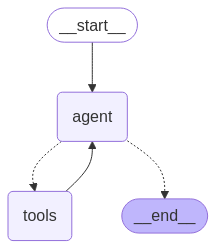

In [95]:
response_agent

In [96]:
config = {"configurable": {"langgraph_user_id": "Plaban"}}

In [97]:
response_agent.invoke({"messages":[{"role":"user","content":"What is the availability for Tuesday"}]},config=config)

{'messages': [HumanMessage(content='What is the availability for Tuesday', additional_kwargs={}, response_metadata={}, id='7005b579-a019-46e0-9e6c-d142b075298d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_12vn', 'function': {'arguments': '{"day": "Tuesday"}', 'name': 'check_calendar_availability'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 933, 'total_tokens': 950, 'completion_time': 0.061818182, 'prompt_time': 0.059918984, 'queue_time': 0.255777121, 'total_time': 0.121737166}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0ee36a6c-62ad-4596-a56b-50826ec19877-0', tool_calls=[{'name': 'check_calendar_availability', 'args': {'day': 'Tuesday'}, 'id': 'call_12vn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 933, 'output_tokens': 17, 'total_tokens': 950}),
  ToolMessage(content='Available times on Tuesda

## Build Graph Workflow

In [98]:
email_agent = StateGraph(State)
email_agent.add_node(triage_router)
email_agent.add_node("response_agent", response_agent)
email_agent.add_edge(START, "triage_router")
email_agent_workflow = email_agent.compile(store=store)

### Setup Agent to update Long Term Memory in the background
email_agent is now setup to pull its instructions from long-term memory.  
Now, you'll create an agent to update that memory. First check current behavior.

In [102]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "Plaban Nayak <plaban.nayak@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi Plaban,

Urgent issue - your service is down. Is there a reason why""",
}

In [103]:
config = {"configurable": {"langgraph_user_id": "Plaban"}}

In [104]:
response = email_agent_workflow.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [105]:
store.get(("Plaban",), "agent_instructions").value['prompt']

"Use these tools when appropriate to help manage Plaban's tasks efficiently."

In [106]:
store.get(("Plaban",), "triage_respond").value['prompt']

'Direct questions from team members, meeting requests, critical bug reports'

In [107]:
store.get(("Plaban",), "triage_ignore").value['prompt']

'Marketing newsletters, spam emails, mass company announcements'

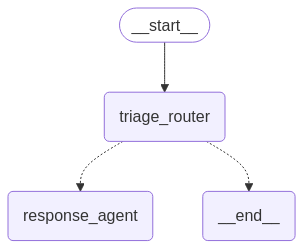

In [108]:
email_agent_workflow

In [109]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'Plaban Nayak <plaban.nayak@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi Plaban,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_37w0)
 Call ID: call_37w0
  Args:
    to: alice.jones@bar.com
    subject: Re: Quick question about API documentation
    content: Hi Alice, 

Thanks for reaching out. Sorry to hear that our service is down. I'll look into this immediately and get back to you with an update. 

Best, 
Plaban Nayak
================================= Tool Message =================================
Name: write_email

Email sent to alice.jones@bar.com with subject 'Re: Quick question about API documentation'
================================== Ai Message ======

In [110]:
response['messages'][-4].content

"Email sent to alice.jones@bar.com with subject 'Re: Quick question about API documentation'"

In [113]:
response['messages'][-2]

ToolMessage(content='created memory fc6cecf6-d266-4ecb-aa49-7ef92ed49834', name='manage_memory', id='ec3e2163-8260-4b71-86b0-374e1e41df2b', tool_call_id='call_n6ph')

In [114]:
response['messages'][-1]

AIMessage(content='<function=search_memory({"query": "service down", "limit": 1})</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1181, 'total_tokens': 1202, 'completion_time': 0.076363636, 'prompt_time': 0.083273586, 'queue_time': 0.249099112, 'total_time': 0.159637222}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_8dd9fca28c', 'finish_reason': 'stop', 'logprobs': None}, id='run-8e28eb41-5e2e-4683-98b1-4b38d2880e41-0', usage_metadata={'input_tokens': 1181, 'output_tokens': 21, 'total_tokens': 1202})

In [116]:
response['messages'][1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_37w0', 'function': {'arguments': '{"to": "alice.jones@bar.com", "subject": "Re: Quick question about API documentation", "content": "Hi Alice, \\n\\nThanks for reaching out. Sorry to hear that our service is down. I\'ll look into this immediately and get back to you with an update. \\n\\nBest, \\nPlaban Nayak"}', 'name': 'write_email'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1000, 'total_tokens': 1083, 'completion_time': 0.301818182, 'prompt_time': 0.072545139, 'queue_time': 0.24842545100000002, 'total_time': 0.374363321}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_90c1d253ff', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1218d9ab-8dc5-47a7-9d18-8c3128d9a0ff-0', tool_calls=[{'name': 'write_email', 'args': {'to': 'alice.jones@bar.com', 'subject': 'Re: Quick question about API documentation', 'content': "Hi Alice, \n\nThank

In [132]:
response['messages'][1].additional_kwargs['tool_calls']

[{'id': 'call_37w0',
  'function': {'arguments': '{"to": "alice.jones@bar.com", "subject": "Re: Quick question about API documentation", "content": "Hi Alice, \\n\\nThanks for reaching out. Sorry to hear that our service is down. I\'ll look into this immediately and get back to you with an update. \\n\\nBest, \\nPlaban Nayak"}',
   'name': 'write_email'},
  'type': 'function'}]

In [139]:
response['messages'][1].additional_kwargs['tool_calls'][0]['function']['arguments']

'{"to": "alice.jones@bar.com", "subject": "Re: Quick question about API documentation", "content": "Hi Alice, \\n\\nThanks for reaching out. Sorry to hear that our service is down. I\'ll look into this immediately and get back to you with an update. \\n\\nBest, \\nPlaban Nayak"}'

### Use an LLM to update instructions.

In [140]:
from langmem import create_multi_prompt_optimizer
conversations = [
    (
        response['messages'],
        "Always sign your email `Plaban Nayak`"
    )
]

In [141]:
store.get(("Plaban",), "triage_notify").value['prompt']

'Team member out sick, build system notifications, project status updates'

In [142]:
prompts = [
    {
        "name": "main_agent",
        "prompt": store.get(("Plaban",), "agent_instructions").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"

    },
    {
        "name": "triage-ignore",
        "prompt": store.get(("Plaban",), "triage_ignore").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"

    },
    {
        "name": "triage-notify",
        "prompt": store.get(("Plaban",), "triage_notify").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails the user should be notified of"

    },
    {
        "name": "triage-respond",
        "prompt": store.get(("Plaban",), "triage_respond").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be responded to"

    },
]

In [143]:
optimizer = create_multi_prompt_optimizer(
    "groq:llama-3.3-70b-versatile",
    kind="prompt_memory",
)

In [218]:
optimizer = create_multi_prompt_optimizer(
    "openai:gpt-4o",
    kind="prompt_memory",
)

In [144]:
updated = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)


In [145]:
updated

[{'name': 'main_agent',
  'prompt': "Use these tools when appropriate to help manage Plaban's tasks efficiently. Always sign your email as 'Plaban Nayak'.",
  'update_instructions': 'keep the instructions short and to the point',
  'when_to_update': 'Update this prompt whenever there is feedback on how the agent should write emails or schedule events'},
 {'name': 'triage-ignore',
  'prompt': 'Marketing newsletters, spam emails, mass company announcements',
  'update_instructions': 'keep the instructions short and to the point',
  'when_to_update': 'Update this prompt whenever there is feedback on which emails should be ignored'},
 {'name': 'triage-notify',
  'prompt': 'Team member out sick, build system notifications, project status updates',
  'update_instructions': 'keep the instructions short and to the point',
  'when_to_update': 'Update this prompt whenever there is feedback on which emails the user should be notified of'},
 {'name': 'triage-respond',
  'prompt': 'Direct questions

In [146]:
#json dumps is a bit easier to read
import json
print(json.dumps(updated, indent=4))

[
    {
        "name": "main_agent",
        "prompt": "Use these tools when appropriate to help manage Plaban's tasks efficiently. Always sign your email as 'Plaban Nayak'.",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"
    },
    {
        "name": "triage-ignore",
        "prompt": "Marketing newsletters, spam emails, mass company announcements",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"
    },
    {
        "name": "triage-notify",
        "prompt": "Team member out sick, build system notifications, project status updates",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on wh

### Update the prompts in the store

In [158]:
for i, updated_prompt in enumerate(updated):
    old_prompt = prompts[i]
    if updated_prompt['prompt'] != old_prompt['prompt']:
        name = old_prompt['name']
        print(f"updated {name}")

        if name == "main_agent":
              store.put(
                  ("lance",),
                  "agent_instructions",
                  {"prompt":updated_prompt['prompt']}
              )
        else:
              store.put(
                  ("Plaban",),
                  name,
                  {"prompt":updated_prompt['prompt']}
              )

        print(f"{name} prompt updated in the store Successfully")
    else:
        print(f"{name} prompt not updated in the store")


updated main_agent
main_agent prompt updated in the store Successfully
main_agent prompt not updated in the store
main_agent prompt not updated in the store
updated triage-respond
triage-respond prompt updated in the store Successfully


In [148]:
for items in updated:
  print(items['name'])
  try:
    print(store.get(("Plaban",), items['name']).value['prompt'])
  except Exception as e:
    pass

main_agent
triage-ignore
triage-notify
triage-respond


In [149]:
store.get(("Plaban",), "agent_instructions").value['prompt']

"Use these tools when appropriate to help manage Plaban's tasks efficiently."

In [151]:
response = email_agent_workflow.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [152]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'Plaban Nayak <plaban.nayak@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi Plaban,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_tsk5)
 Call ID: call_tsk5
  Args:
    to: alice.jones@bar.com
    subject: Re: Quick question about API documentation
    content: Hi Alice, 

I'm so sorry to hear that our service is down. I'll look into this immediately and get back to you with an update. 

Best, 
Plaban Nayak
================================= Tool Message =================================
Name: write_email

Email sent to alice.jones@bar.com with subject 'Re: Quick question about API documentation'
================================== Ai Message ========================

### Follow up email

In [153]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "Plaban Nayak <plaban.nayak@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi Plaban,

Urgent issue - your service is down. Is there a reason why""",
}

In [156]:
response = email_agent_workflow.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [157]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'Plaban Nayak <plaban.nayak@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi Plaban,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_4b5b)
 Call ID: call_4b5b
  Args:
    to: alice.jones@bar.com
    subject: Re: Quick question about API documentation
    content: Hi Alice, 

Thanks for reaching out. I'm looking into the issue with our service being down. Can you please provide more details about the error you're experiencing? I'll get back to you as soon as possible. 

Best, Plaban
================================= Tool Message =================================
Name: write_email

Email sent to alice.jones@bar.com with subject 'Re: Quick question about API documentati

### Update Feedback to ignore mails from Alice

In [215]:
conversations = [
    (
        response['messages'],
        "Always Ignore any emails from Alice Jones"
    )
]

### Define List of prompts beacuse the old list of prompts has been outdated for the main agent

In [216]:
prompts = [
    {
        "name": "main_agent",
        "prompt": store.get(("Plaban",), "agent_instructions").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"

    },
    {
        "name": "triage-ignore",
        "prompt": store.get(("Plaban",), "triage_ignore").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"

    },
    {
        "name": "triage-notify",
        "prompt": store.get(("Plaban",), "triage_notify").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails the user should be notified of"

    },
    {
        "name": "triage-respond",
        "prompt": store.get(("Plaban",), "triage_respond").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be responded to"

    },
]

In [219]:
updated = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)

In [220]:
store.get(("Plaban",), "triage_ignore").value['prompt']

'Marketing newsletters, spam emails, mass company announcements'

### Update the prompts in long term memory

In [221]:
for i, updated_prompt in enumerate(updated):
    old_prompt = prompts[i]
    if updated_prompt['prompt'] != old_prompt['prompt']:
        name = old_prompt['name']
        print(f"updated {name}")
        if name == "main_agent":
            store.put(
                ("Plaban",),
                "agent_instructions",
                {"prompt":updated_prompt['prompt']}
            )
        if name == "triage-ignore":
            store.put(
                ("Plaban",),
                "triage_ignore",
                {"prompt":updated_prompt['prompt']}
            )
        else:
            #raise ValueError
            print(f"Encountered {name}, implement the remaining stores!")

updated main_agent
Encountered main_agent, implement the remaining stores!
updated triage-ignore


In [222]:
store.get(("Plaban",), "triage_ignore").value['prompt']

'<updated_prompt>\nMarketing newsletters, spam emails, mass company announcements\n\nAdditionally, always ignore any emails from Alice Jones.\n</updated_prompt>'

In [223]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "Plaban Nayak <plaban.nayak@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi Plaban,

Any Updates""",
}

### Invoke Optimizer Agent

In [224]:
response = email_agent_workflow.invoke(
    {"email_input": email_input},
    config=config
)

🚫 Classification: IGNORE - This email can be safely ignored


In [225]:
for m in response["messages"]:
    m.pretty_print()

In [226]:
store.get(("Plaban",), "triage_ignore").value['prompt']

'<updated_prompt>\nMarketing newsletters, spam emails, mass company announcements\n\nAdditionally, always ignore any emails from Alice Jones.\n</updated_prompt>'

In [177]:
store.get(("Plaban",), "triage_respond").value['prompt']

'Direct questions from team members, meeting requests, critical bug reports'

In [227]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "Plaban Nayak <plaban.nayak@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi Plaban,

I encounter a 404 error whenever I try to acces the endpoint supplied by your team.""",
}

In [228]:
response = email_agent_workflow.invoke(
    {"email_input": email_input},
    config=config
)

🚫 Classification: IGNORE - This email can be safely ignored


In [229]:
for m in response["messages"]:
    m.pretty_print()